In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import scvelo as scv
import scrublet as scr
import scanpy.external as sce
import numpy as np
import pandas as pd
import scanpy as sc
import phate
import scvelo as scv
import statistics

scv.logging.print_version()
scv.settings.verbosity = 3  
scv.settings.set_figure_params('scvelo')

Running scvelo 0.2.4 (python 3.9.7) on 2023-08-21 11:31.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


In [13]:
# load files
adata1=sc.read("../HEK293/Deconvoluted_files/10x_25k_subset_names.csv")
adata2=sc.read("../HEK293/Deconvoluted_files/spindrop_25k_subset_names.csv")
adata3=sc.read("../HEK293/Deconvoluted_files/sindrop_25k_subset_names.csv")
adata1.var_names_make_unique()
adata2.var_names_make_unique()
adata3.var_names_make_unique()
ldata1 = scv.read("10x_H.loom", cache=True)
adata1 = scv.utils.merge(adata1, ldata1)
ldata2 = scv.read("Spindrop13__H.loom", cache=True)
adata2 = scv.utils.merge(adata2, ldata2)
ldata3 = scv.read("sindrop_H.loom", cache=True)
adata3 = scv.utils.merge(adata3, ldata3)
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.normalize_total(adata2, target_sum=1e4)
sc.pp.normalize_total(adata3, target_sum=1e4)
adata1.obs["type"]="10x"
adata2.obs["type"]="spinDrop"
adata3.obs["type"]="inDrop"
adata1.var['mt'] = adata1.var_names.str.contains('MT')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata2.var['mt'] = adata2.var_names.str.contains('MT')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata3.var['mt'] = adata3.var_names.str.contains('MT')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata3, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [14]:
#removing mouse barcodes
adata2 = adata2[adata2.obs.pct_counts_mt >8, :]

In [8]:
adata = adata1.concatenate(adata2, adata3, batch_categories = ['10x','spinDrop',"inDrop"], join = 'outer')


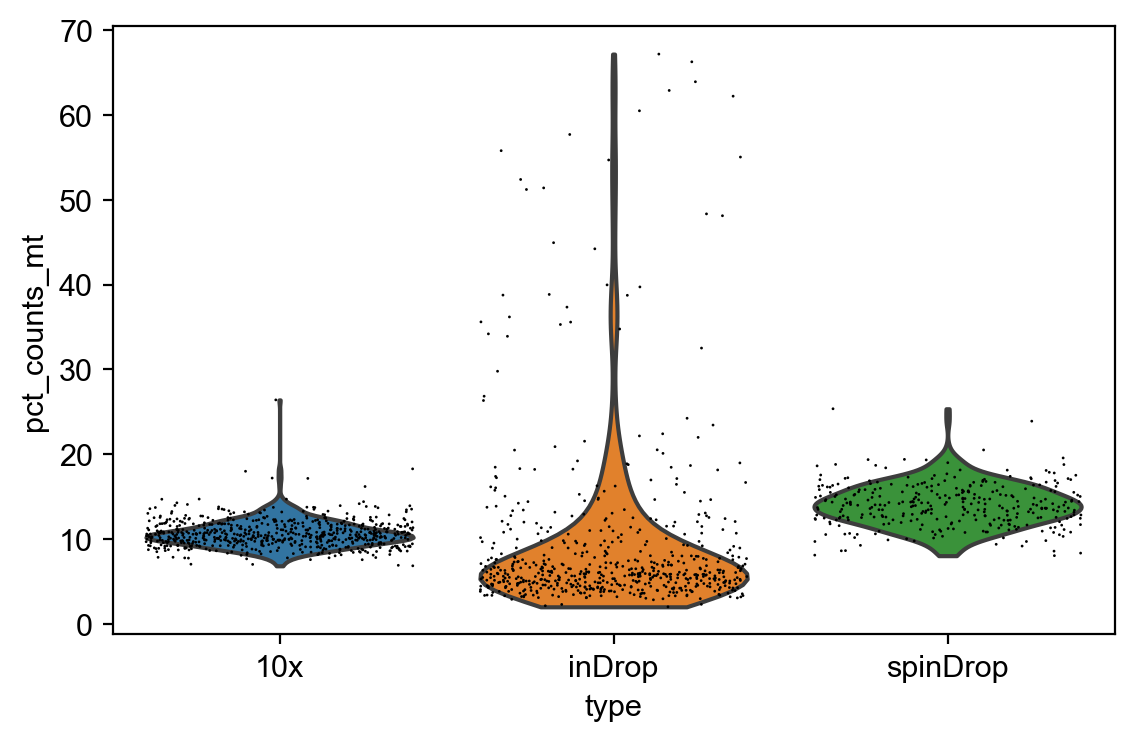

In [9]:
sc.pl.violin(adata, ['pct_counts_mt'],
             jitter=0.4, multi_panel=True,  groupby="type")

In [15]:
# normalize, dimensional reduction etc.
sc.pp.log1p(adata1)
sc.pp.log1p(adata2)
sc.pp.log1p(adata3)
sc.pp.highly_variable_genes(adata1, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata3, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata1.raw = adata1
adata2.raw = adata2
adata3.raw = adata3
sc.pp.regress_out(adata1, ['total_counts', 'pct_counts_mt'])
sc.pp.regress_out(adata2, ['total_counts', 'pct_counts_mt'])
sc.pp.regress_out(adata3, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata1, max_value=10)
sc.pp.scale(adata2, max_value=10)
sc.pp.scale(adata3, max_value=10)
sc.tl.pca(adata1, svd_solver='arpack')
sc.tl.pca(adata2, svd_solver='arpack')
sc.tl.pca(adata3, svd_solver='arpack')
sc.pp.neighbors(adata1, n_neighbors=10, n_pcs=40)
sc.pp.neighbors(adata2, n_neighbors=10, n_pcs=40)
sc.pp.neighbors(adata3, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata1)
sc.tl.leiden(adata2)
sc.tl.leiden(adata3)
cell_cycle_genes = [x.strip() for x in open('./regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata1, s_genes=s_genes, g2m_genes=g2m_genes)
sc.tl.score_genes_cell_cycle(adata2, s_genes=s_genes, g2m_genes=g2m_genes)
sc.tl.score_genes_cell_cycle(adata3, s_genes=s_genes, g2m_genes=g2m_genes)

In [16]:
#velocity computation
scv.pp.moments(adata1, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata2, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata3, n_pcs=30, n_neighbors=30)
scv.tl.recover_dynamics(adata1)
scv.tl.recover_dynamics(adata2)
scv.tl.recover_dynamics(adata3)
scv.tl.velocity(adata1, mode='dynamical')
scv.tl.velocity(adata2, mode='dynamical')
scv.tl.velocity(adata3, mode='dynamical')

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/6 cores)


  0%|          | 0/343 [00:00<?, ?gene/s]

    finished (0:00:44) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
recovering dynamics (using 1/6 cores)


  0%|          | 0/224 [00:00<?, ?gene/s]

    finished (0:00:21) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
recovering dynamics (using 1/6 cores)


  0%|          | 0/246 [00:00<?, ?gene/s]

    finished (0:00:32) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [17]:
# score cell cycle
scv.tl.velocity_graph(adata1)
scv.tl.velocity_graph(adata2)
scv.tl.velocity_graph(adata3)
sc.tl.umap(adata1)
sc.tl.umap(adata2)
sc.tl.umap(adata3)
scv.tl.score_genes_cell_cycle(adata1)
scv.tl.score_genes_cell_cycle(adata2)
scv.tl.score_genes_cell_cycle(adata3)

computing velocity graph (using 1/6 cores)


  0%|          | 0/666 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/6 cores)


  0%|          | 0/326 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/6 cores)


  0%|          | 0/605 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)
calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)
calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


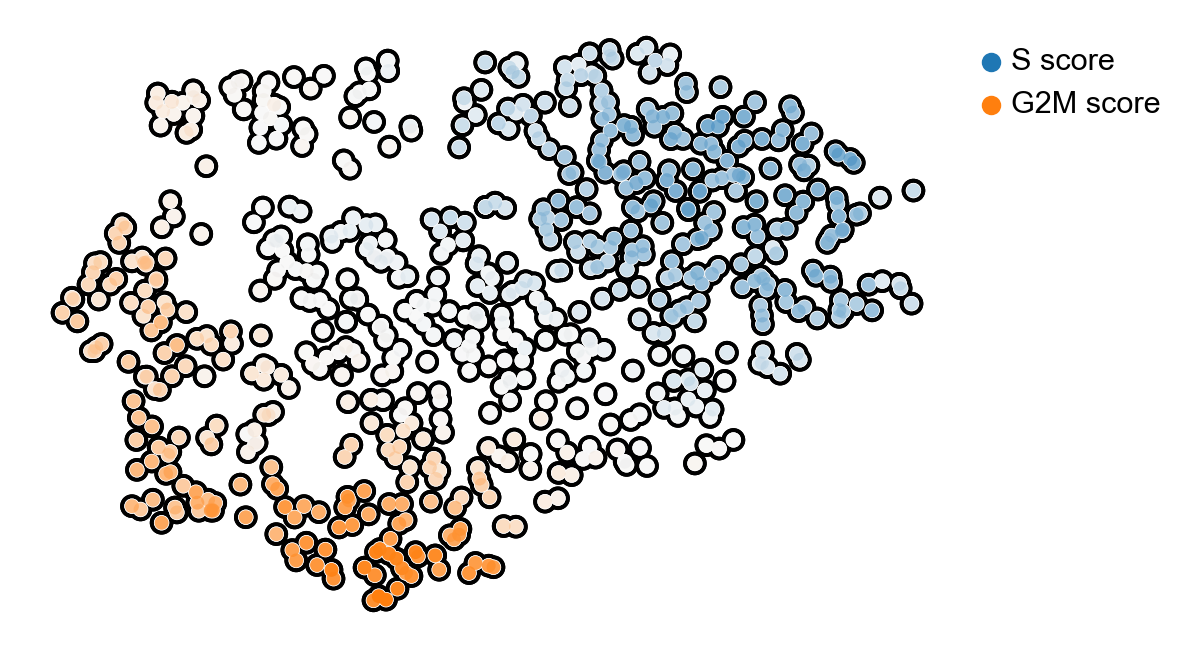

In [18]:
#10x
scv.pl.scatter(adata1, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95],add_outline=True,size =100)

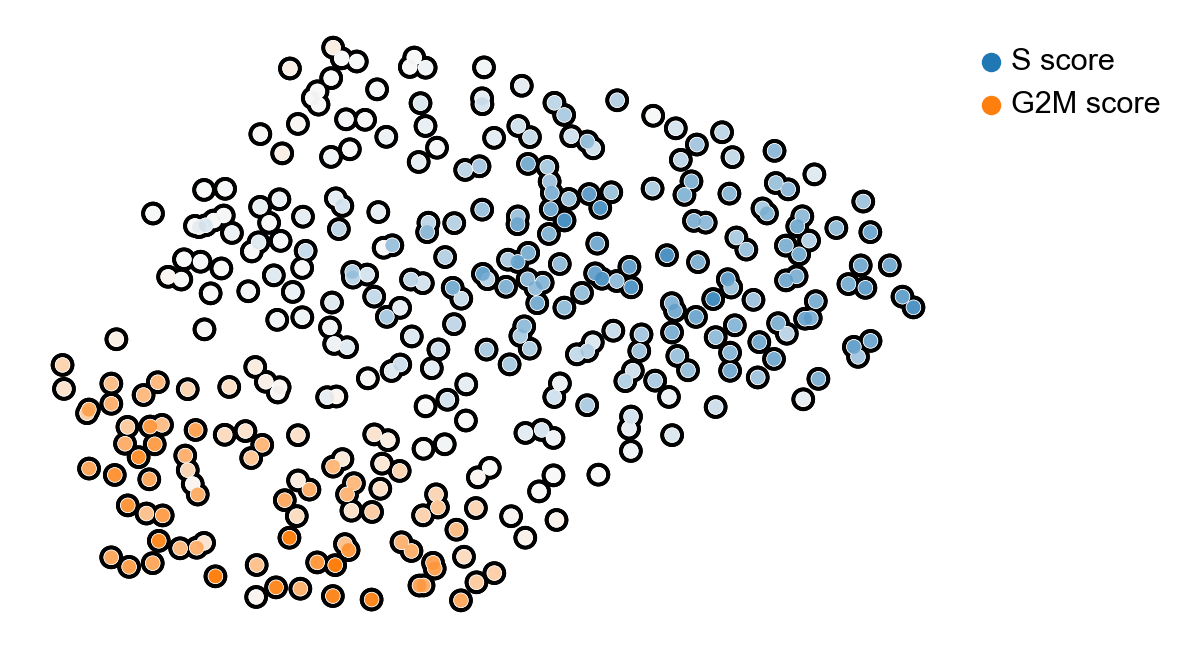

In [19]:
#spindrop
scv.pl.scatter(adata2, color_gradients=['S_score', 'G2M_score'], smooth=True,add_outline=True,size =100, perc=[5, 95])

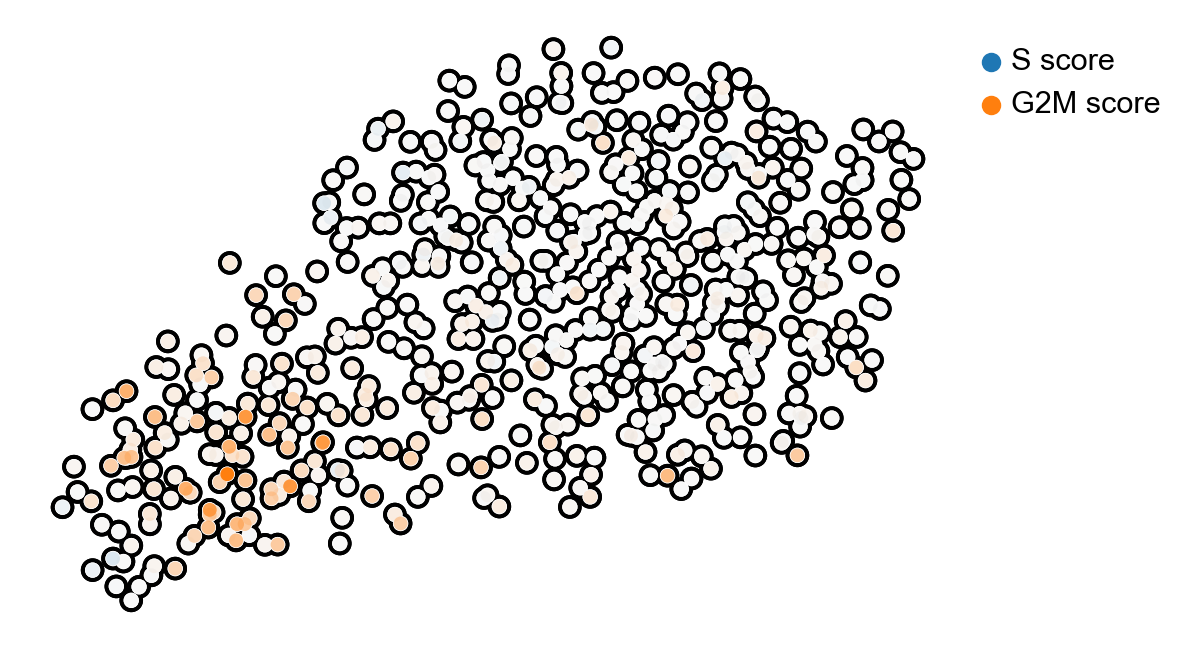

In [20]:
#inDrop
scv.pl.scatter(adata3, color_gradients=['S_score', 'G2M_score'],add_outline=True,size =100, smooth=True, perc=[5, 95])

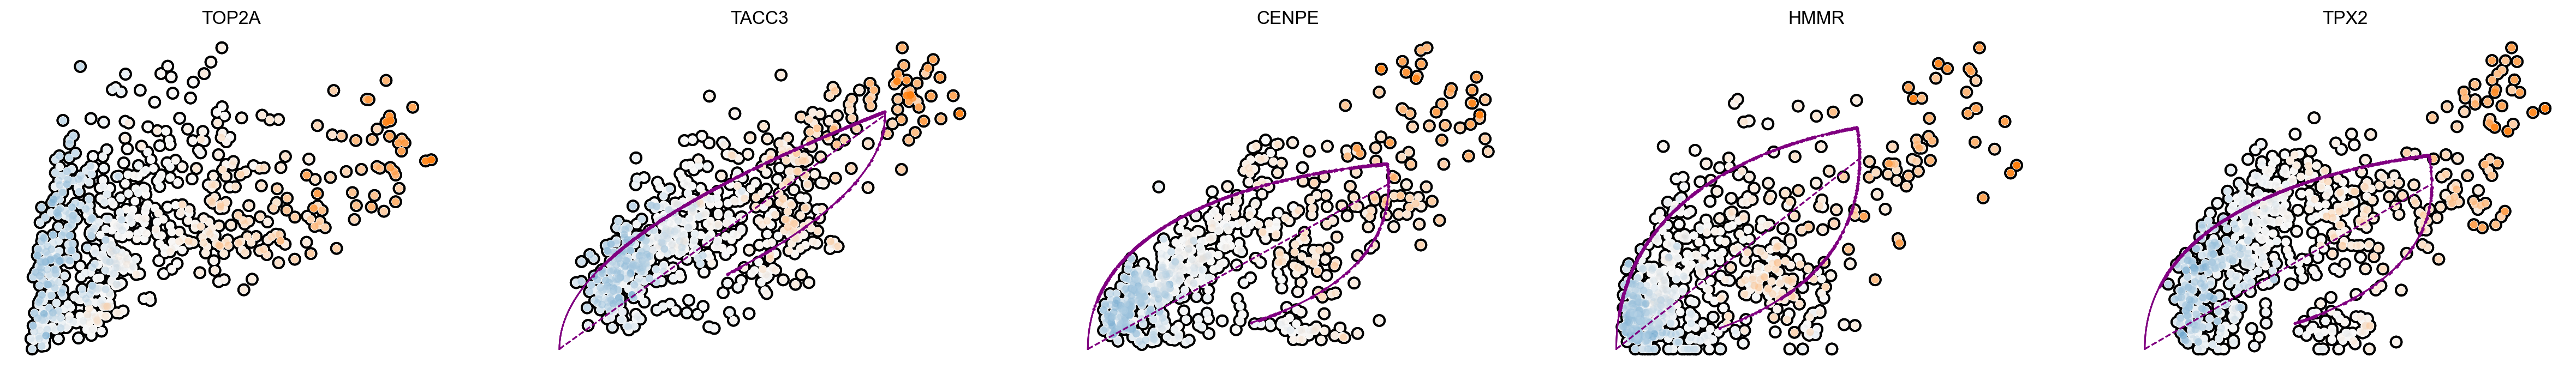

In [21]:
#10x cerll cycle
scv.pl.scatter(adata1, basis=["TOP2A","TACC3","CENPE","HMMR","TPX2"],add_outline=True, size=100, ncols=5, frameon=False, color_gradients=['S_score', 'G2M_score'])

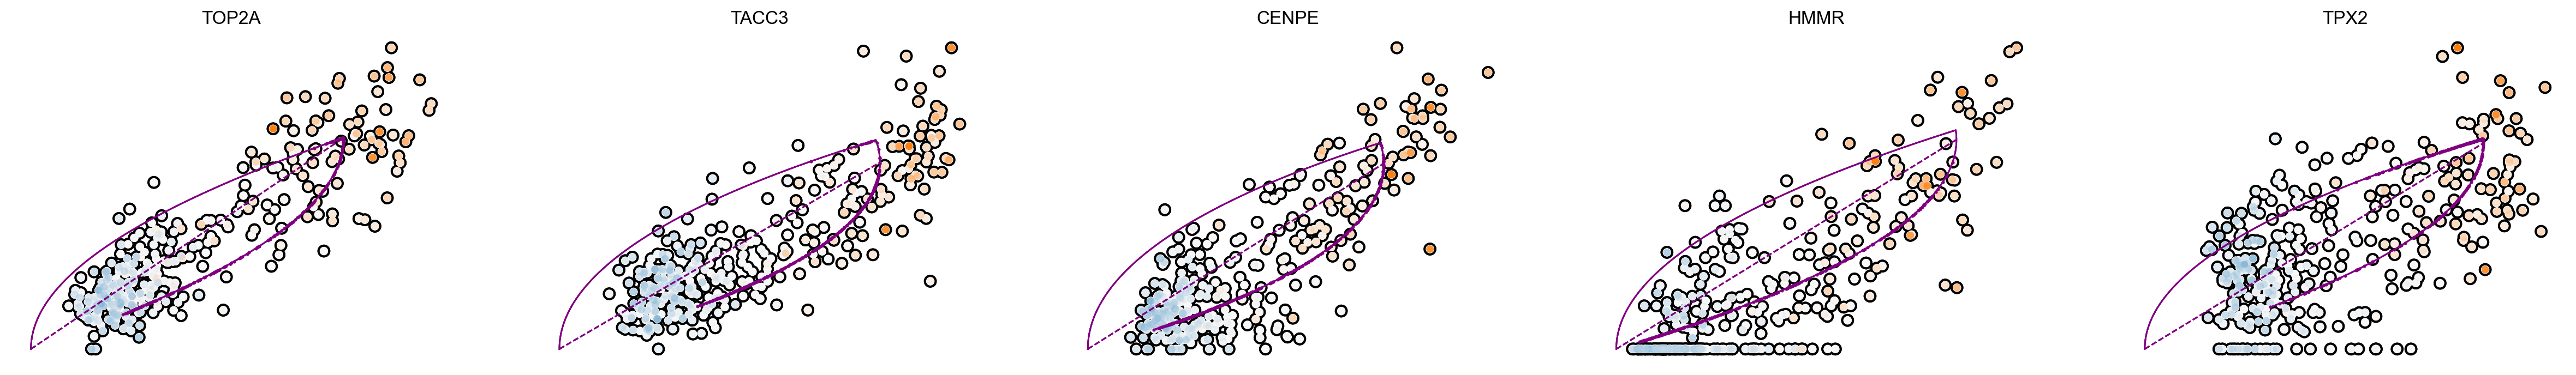

In [22]:
#spindrop cell cycle
scv.pl.scatter(adata2, basis=["TOP2A","TACC3","CENPE","HMMR","TPX2"],add_outline=True, size=100, ncols=5, frameon=False, color_gradients=['S_score', 'G2M_score'])

In [ ]:
scv.pl.scatter(adata3, basis=["TOP2A","TACC3","CENPE","HMMR","TPX2"],add_outline=True, size=100, ncols=5, frameon=False, color_gradients=['S_score', 'G2M_score'], save="indrop_cell_cycle.svg")